# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector

## 1. Data Loading and Exploration

In [2]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=100000, n_test=60000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")

# dataset 2 with different anomaly process
path_anom2 = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset2 = _load_h5_challenge_dataset(path_bkg, path_anom2, n_train=100000, n_test=60000)
# Print dataset information
print(f"Training set shape: {dataset2.train.shape}")
print(f"Test set shape: {dataset2.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset2.test_labels)}")


Loading datasets...
Training set shape: (100000, 76)
Test set shape: (115969, 76)
Number of anomalies in test set: 55969.0
Loading datasets...
Training set shape: (100000, 76)
Test set shape: (120000, 76)
Number of anomalies in test set: 60000.0


## 2. Data Preprocessing

In [3]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")
X_test2 = preprocessor.transform(dataset2.test)

Preprocessing data...
Done


## 3. t-SNE Visualization

t-SNE reduces dimensionality while preserving local structure, helping us visualize high-dimensional data.

In [4]:
# Visualize data with t-SNE (subsample for speed)
# print("Visualizing data with t-SNE (this may take a while)...")
# subsample_size = min(5000, len(X_test))
# indices = np.random.choice(len(X_test), subsample_size, replace=False)

# tsne_preprocessor = Preprocessor([TSNEFunction(n_components=2)])
# X_test_tsne = tsne_preprocessor.transform(X_test[indices], fit=True)
# y_test_tsne = dataset.test_labels[indices]

# # Plot t-SNE visualization
# plt.figure(figsize=(10, 8))
# plt.scatter(
#     X_test_tsne[y_test_tsne == 0, 0],
#     X_test_tsne[y_test_tsne == 0, 1],
#     c="blue",
#     alpha=0.5,
#     label="Normal",
# )
# plt.scatter(
#     X_test_tsne[y_test_tsne == 1, 0],
#     X_test_tsne[y_test_tsne == 1, 1],
#     c="red",
#     alpha=0.5,
#     label="Anomaly",
# )
# plt.title("t-SNE Visualization of Test Data")
# plt.legend()
# plt.tight_layout()
# plt.show()

## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [5]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [6]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

results["Isolation Forest"] = {
    "scores": iso_scores,
    "auc": iso_auc,
    "ap": iso_ap,
    "time": iso_time,
}

Training Isolation Forest...


Training time: 0.52 seconds
Accuracy: 0.4152
AUC-ROC: 0.8851
Average Precision: 0.8662


In [7]:
print(X_train.shape[1])

76


### 4.2 Flow Matching

In [8]:
print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size= config["batch_size"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.fit(X_train)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")



Training Flow Matching (this may take a while)...
| iter      1 | 2481.65 ms/step | loss    1.369 
| iter      2 | 2259.57 ms/step | loss    1.529 
| iter      3 | 2052.36 ms/step | loss    1.270 
| iter      4 | 2170.44 ms/step | loss    1.260 
| iter      5 | 2250.31 ms/step | loss    1.444 
| iter      6 | 3726.97 ms/step | loss    1.518 
| iter      7 | 5361.09 ms/step | loss    1.274 
| iter      8 | 4080.33 ms/step | loss    1.275 
| iter      9 | 2895.48 ms/step | loss    1.444 
| iter     10 | 7054.15 ms/step | loss    1.179 
| iter     11 | 9582.10 ms/step | loss    1.166 
| iter     12 | 12559.87 ms/step | loss    1.189 
| iter     13 | 5950.77 ms/step | loss    1.127 
| iter     14 | 6988.16 ms/step | loss    1.135 
| iter     15 | 4941.12 ms/step | loss    1.153 
| iter     16 | 5939.79 ms/step | loss    1.378 
| iter     17 | 7110.96 ms/step | loss    1.355 
| iter     18 | 5997.51 ms/step | loss    1.158 
| iter     19 | 6119.21 ms/step | loss    1.147 
| iter     20 | 57

In [9]:
# Predict anomaly scores
flow_scores, _ = flow_matching.predict(X_test, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": 1,
}

Mean score for normal samples: 4.4443
Std score for normal samples: 8.8975
Mean score for anomalous samples: 59.8992
Std score for anomalous samples: 137.5738
Accuracy: 0.7577
AUC-ROC: 0.8563
Average Precision: 0.8706


In [10]:
# Predict anomaly scores
flow_scores2, _ = flow_matching.predict(X_test2, mode="vt")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores2[dataset2.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores2[dataset2.test_labels == 1]):.4f}"
)
flow_auc2 = roc_auc_score(dataset2.test_labels, flow_scores2)
flow_ap2 = average_precision_score(dataset2.test_labels, flow_scores2)
flow_accuracy2 = accuracy_score(dataset2.test_labels, flow_scores2 > 10)
# manually compute accuracy
print(f"Accuracy: {flow_accuracy2:.4f}")
print(f"AUC-ROC: {flow_auc2:.4f}")
print(f"Average Precision: {flow_ap2:.4f}")

results["Flow Matching2"] = {
    "scores": flow_scores2,
    "auc": flow_auc2,
    "ap": flow_ap2,
    "time": 1,
}

Mean score for normal samples: 4.4443
Std score for normal samples: 8.8975
Mean score for anomalous samples: 12.9603
Std score for anomalous samples: 26.0510
Accuracy: 0.6267
AUC-ROC: 0.7528
Average Precision: 0.7703


torch.Size([100, 5, 76])
torch.Size([100, 5, 76])


Text(0.5, 0.01, '○: Initial state   •: Intermediate states   ★: Final state')

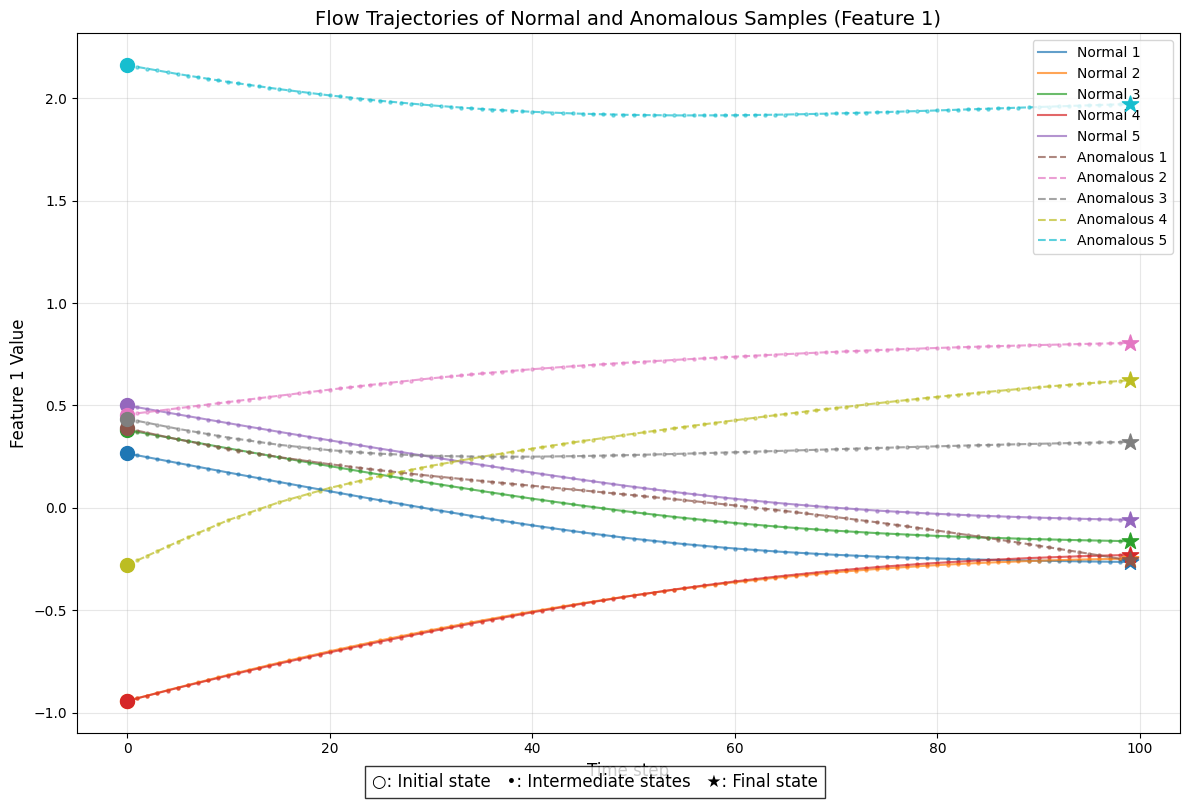

In [11]:
# try and plot some trajectories for normal and anomalous samples
# get the indices of the normal and anomalous samples
normal_indices = np.where(dataset.test_labels == 0)[0]
anomalous_indices = np.where(dataset.test_labels == 1)[0]
# get the first 5 indices of each
normal_indices = normal_indices[:5]
anomalous_indices = anomalous_indices[:5]
# plot the trajectories for the normal samples
normal_trajectories = flow_matching.return_trajectories(
    X_test[normal_indices], mode="ODE"
).swapaxes(0, 1)
anom_trajectories = flow_matching.return_trajectories(
    X_test[anomalous_indices], mode="ODE"
).swapaxes(0, 1)

# Create a figure for the first feature trajectory visualization
plt.figure(figsize=(12, 8))

# Plot the trajectories
for i, trajectory in enumerate(normal_trajectories):
    plt.plot(trajectory[:, 4], label=f"Normal {i+1}", color=f"C{i}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(range(len(trajectory)), trajectory[:, 4], marker='.', color=f"C{i}", s=20, alpha=0.5)
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker='o', color=f"C{i}", s=100, zorder=10)
    plt.scatter(len(trajectory)-1, trajectory[-1, 4], marker='*', color=f"C{i}", s=150, zorder=10)

for i, trajectory in enumerate(anom_trajectories):
    plt.plot(trajectory[:, 4], label=f"Anomalous {i+1}", linestyle="--", color=f"C{i+5}", alpha=0.7)
    # Add small scatter points for all states
    plt.scatter(range(len(trajectory)), trajectory[:, 4], marker='.', color=f"C{i+5}", s=20, alpha=0.5)
    # Highlight initial and final states
    plt.scatter(0, trajectory[0, 4], marker='o', color=f"C{i+5}", s=100, zorder=10)
    plt.scatter(len(trajectory)-1, trajectory[-1, 4], marker='*', color=f"C{i+5}", s=150, zorder=10)

# Add visual enhancements
plt.title("Flow Trajectories of Normal and Anomalous Samples (Feature 1)", fontsize=14)
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Feature 1 Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()

# Add a text annotation explaining the markers
plt.figtext(0.5, 0.01, "○: Initial state   •: Intermediate states   ★: Final state", 
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

In [12]:
# # save the model, then load it
# flow_matching.save("flow_matching_model.pt")
# flow_matching_loaded  = FlowMatchingAnomalyDetector(
#     input_dim=X_train.shape[1],
#     hidden_dim=config["hidden_dim"],
#     model_type=config["model_type"],
#     num_layers=config["num_layers"],
#     dropout_rate=config["dropout_rate"],
#     use_batch_norm=config["use_batch_norm"],
#     lr=config["lr"],
#     batch_size= config["batch_size"],
#     iterations=config["iterations"],
#     print_every=config["print_every"],
#     device=config["device"],
# )
# flow_matching_loaded.load("flow_matching_model.pt")
# # Predict anomaly scores
# flow_scores_loaded, _ = flow_matching_loaded.predict(X_test, mode="ODE")
# # print mean and std of scores for normal and anomalous samples
# print(
#     f"Mean score for normal samples: {np.mean(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
# )
# print(
#     f"Std score for normal samples: {np.std(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
# )


## 5. Model Comparison and Visualization

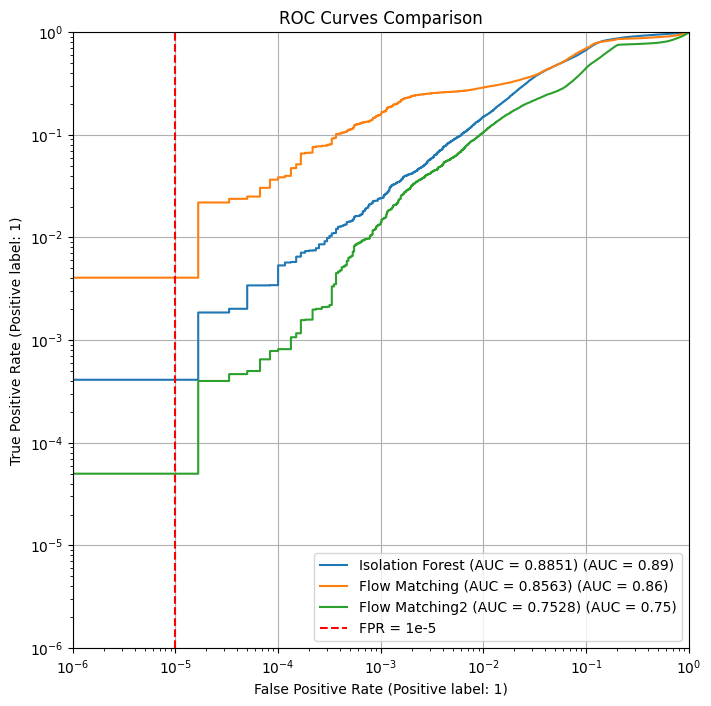

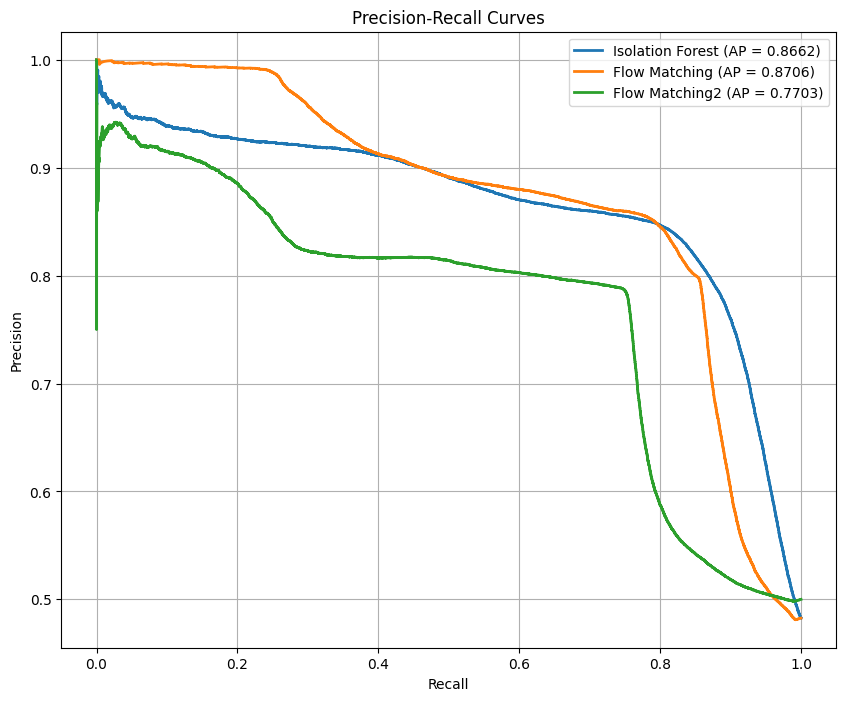

In [13]:
# Compare ROC curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if name == "Flow Matching2":
        # use the second dataset for this model
        RocCurveDisplay.from_predictions(
            dataset2.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )
    else:
        RocCurveDisplay.from_predictions(
            dataset.test_labels,
            result["scores"],
            name=f"{name} (AUC = {result['auc']:.4f})",
            ax=plt.gca(),
        )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-6, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    if name == "Flow Matching2":
        # use the second dataset for this model
        precision, recall, _ = precision_recall_curve(dataset2.test_labels, result["scores"])
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")
    else:
        precision, recall, _ = precision_recall_curve(dataset.test_labels, result["scores"])
        plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

(60000,)
(60000,)
mean score for normal samples: 2.937405824661255
mean score for anomalous samples: 59.43678665161133
(60000,)
mean score for normal samples: 2.937405824661255
mean score for anomalous samples: 12.956281661987305


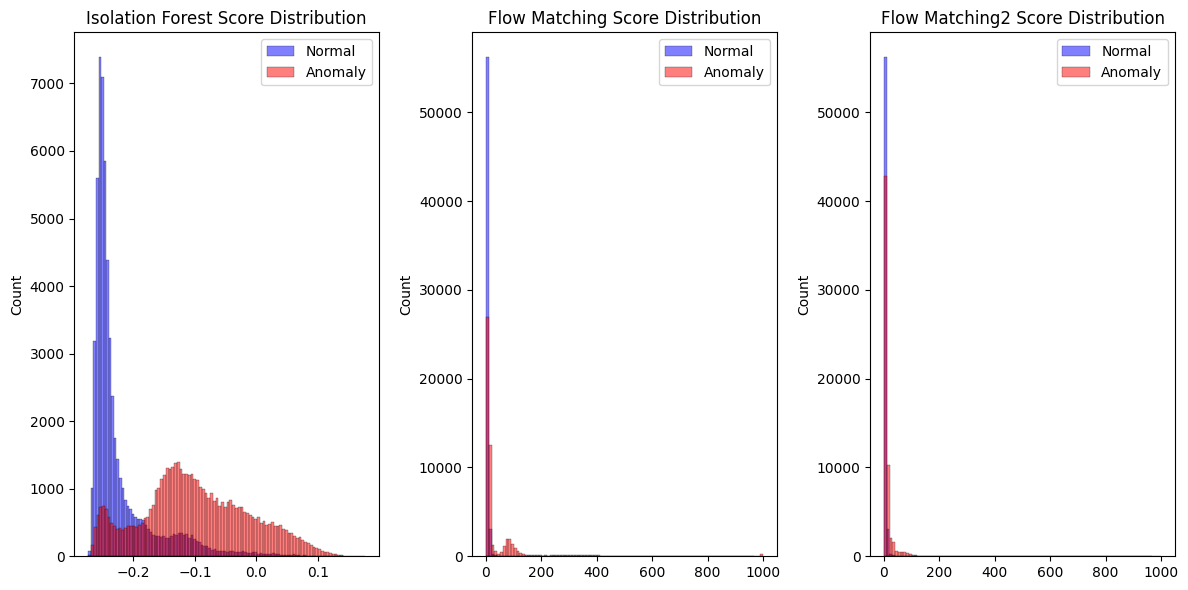

In [14]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, len(results), i)

    # Separate scores for normal and anomaly classes
    if name == "Flow Matching2":
        # use the second dataset for this model
        normal_scores = result["scores"][dataset2.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset2.test_labels == 1]
    else:
        normal_scores = result["scores"][dataset.test_labels == 0]
        print(normal_scores.shape)
        anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

## 7. Results Summary

In [15]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )

==== Summary of Results ====
Model                AUC-ROC    Avg Precision   Training Time (s)
------------------------------------------------------------
Isolation Forest     0.8851     0.8662          0.52           
Flow Matching        0.8563     0.8706          1.00           
Flow Matching2       0.7528     0.7703          1.00           
